<a href="https://colab.research.google.com/github/leizhouChina/lab_3_Part_2/blob/main/lab3_Part2_WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Part 2: Word and Sentence Embeddings

**Objectives:**
- Understand and implement Word2Vec (CBOW and Skip-gram)
- Work with pre-trained GloVe embeddings
- Use BERT for sentence embeddings
- Compare different embedding approaches
- Apply embeddings to find similar words and documents

---

## Instructions

1. Complete all exercises marked with `# YOUR CODE HERE`
2. **Answer all written questions** in the designated markdown cells
3. Save your completed notebook
4. **Push to your Git repository and send the link to: yoroba93@gmail.com**

### Important: This lab continues from Part 1

You will use the same dataset and categories you chose in Part 1.

---

## Setup

In [1]:
# Install required libraries (uncomment if needed)
# !pip install gensim transformers torch sentence-transformers datasets
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 43.3 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import string
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix the LookupError

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api

print(f"Gensim version: {gensim.__version__}")
print("Setup complete!")

Gensim version: 4.4.0
Setup complete!


## Load Dataset (Same as Part 1)

In [5]:
import pandas as pd

# Load the dataset
from datasets import load_dataset
dataset = load_dataset('SetFit/20_newsgroups')# YOUR CODE HERE
df = dataset['train'].to_pandas()

# TODO: Use the SAME 3 categories you chose in Part 1!
my_categories = ["rec.sport.hockey", "soc.religion.christian", "rec.motorcycles"]  # COPY FROM PART 1

# Filter dataset
df_filtered = df[df['label_text'].isin(my_categories)].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"Selected categories: {my_categories}")
print(f"Filtered dataset size: {len(df_filtered)}")

Repo card metadata block was not found. Setting CardData to empty.


Selected categories: ['rec.sport.hockey', 'soc.religion.christian', 'rec.motorcycles']
Filtered dataset size: 1797


In [9]:
# Preprocessing function (same as Part 1)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text for embedding training."""
    # lowercase, remove emails, URLs, numbers, punctuation
    text = text.lower() # YOUR CODE HERE  => the same as in Part 1 (advanced preprocessing)
    text = re.sub(r'http?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)

    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token not in stop_words and len(token) > 2]

    return tokens  # Return list of tokens for Word2Vec

# Apply preprocessing
df_filtered['tokens'] = df_filtered['text'].apply(preprocess_text)
df_filtered['text_clean'] = df_filtered['tokens'].apply(' '.join)

print(f"Sample tokens: {df_filtered.iloc[0]['tokens'][:20]}")

Sample tokens: ['line', 'ducati', 'gts', 'model', 'clock', 'run', 'well', 'paint', 'bronzebrownorange', 'faded', 'leak', 'bit', 'oil', 'pop', 'hard', 'accel', 'shop', 'fix', 'trans', 'oil']


---

## Part A: Word2Vec - Training Your Own Embeddings

Word2Vec learns word representations by predicting context. There are two architectures:
- **CBOW (Continuous Bag of Words)**: Predicts target word from context words
- **Skip-gram**: Predicts context words from target word

### A.1 Understanding Word2Vec Architectures

In [10]:
# Prepare corpus for Word2Vec (list of tokenized sentences)
corpus = df_filtered['tokens'].tolist()

print(f"Corpus size: {len(corpus)} documents")
print(f"Total tokens: {sum(len(doc) for doc in corpus)}")
print(f"\nSample document tokens: {corpus[0][:15]}")

Corpus size: 1797 documents
Total tokens: 161761

Sample document tokens: ['line', 'ducati', 'gts', 'model', 'clock', 'run', 'well', 'paint', 'bronzebrownorange', 'faded', 'leak', 'bit', 'oil', 'pop', 'hard']


In [11]:
# Train Word2Vec with CBOW (sg=0)
model_cbow = Word2Vec(
    sentences=corpus,
    vector_size=100,      # Embedding dimension
    window=5,             # Context window size
    min_count=5,          # Ignore words with freq < 5
    workers=4,            # Parallel threads
    sg=0,                 # 0 = CBOW, 1 = Skip-gram
    epochs=10             # Training epochs
)

print(f"CBOW Model trained!")
print(f"Vocabulary size: {len(model_cbow.wv)}")

CBOW Model trained!
Vocabulary size: 4761


In [12]:
# Train Word2Vec with Skip-gram (sg=1)
model_skipgram = Word2Vec(
    sentences=corpus,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1,                 # Skip-gram
    epochs=10
)

print(f"Skip-gram Model trained!")
print(f"Vocabulary size: {len(model_skipgram.wv)}")

Skip-gram Model trained!
Vocabulary size: 4761


### A.2 Exploring Word Embeddings

In [13]:
# Example: Get word vector
sample_word = "hockey"  # Change this to a word relevant to YOUR categories

if sample_word in model_cbow.wv:
    vector = model_cbow.wv[sample_word]
    print(f"Vector for '{sample_word}':")
    print(f"  Shape: {vector.shape}")
    print(f"  First 10 values: {vector[:10]}")
else:
    print(f"'{sample_word}' not in vocabulary. Try another word.")
    print(f"Sample words in vocab: {list(model_cbow.wv.key_to_index.keys())[:20]}")

Vector for 'hockey':
  Shape: (100,)
  First 10 values: [-0.01943468  0.99319774  0.22853102 -1.3025966  -0.77389735 -0.34933773
  0.6372369   1.132457   -0.33196068 -0.66670173]


In [14]:
# Find similar words
sample_word = "hockey"  # Change to a word in YOUR vocabulary

if sample_word in model_cbow.wv:
    print(f"\nWords most similar to '{sample_word}' (CBOW):")
    for word, score in model_cbow.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")

    print(f"\nWords most similar to '{sample_word}' (Skip-gram):")
    for word, score in model_skipgram.wv.most_similar(sample_word, topn=10):
        print(f"  {word}: {score:.4f}")


Words most similar to 'hockey' (CBOW):
  nhl: 0.9839
  team: 0.9805
  league: 0.9783
  playoff: 0.9672
  player: 0.9648
  playing: 0.9643
  european: 0.9625
  regular: 0.9542
  game: 0.9529
  played: 0.9527

Words most similar to 'hockey' (Skip-gram):
  college: 0.7681
  basketball: 0.7583
  attended: 0.7476
  ncaa: 0.7320
  canadian: 0.7223
  europe: 0.7163
  international: 0.7157
  america: 0.7103
  professional: 0.7066
  central: 0.7060


### Exercise A.1: Compare CBOW vs Skip-gram

Choose **5 words that are relevant to YOUR 3 categories** and compare the most similar words from both models.

In [17]:
# TODO: Choose 5 words relevant to YOUR categories
# These should be domain-specific words (not common words like "good", "make", etc.)

my_test_words = ["hockey", "god", "bike", "player", "faith"]  # YOUR WORDS HERE

comparison_results = []

for word in my_test_words:
    word = word.lower()
    if word in model_cbow.wv and word in model_skipgram.wv:
        cbow_similar = [w for w, s in model_cbow.wv.most_similar(word, topn=5)]
        skipgram_similar = [w for w, s in model_skipgram.wv.most_similar(word, topn=5)]

        comparison_results.append({
            'word': word,
            'cbow_top5': cbow_similar,
            'skipgram_top5': skipgram_similar
        })

        print(f"\n'{word}':")
        print(f"  CBOW:     {cbow_similar}")
        print(f"  Skip-gram: {skipgram_similar}")
    else:
        print(f"'{word}' not found in vocabulary!")


'hockey':
  CBOW:     ['nhl', 'team', 'league', 'playoff', 'player']
  Skip-gram: ['college', 'basketball', 'attended', 'ncaa', 'canadian']

'god':
  CBOW:     ['sin', 'man', 'lord', 'heaven', 'human']
  Skip-gram: ['sinner', 'glory', 'mercy', 'gift', 'wicked']

'bike':
  CBOW:     ['ride', 'get', 'around', 'motorcycle', 'back']
  Skip-gram: ['honda', 'mile', 'car', 'smooth', 'gear']

'player':
  CBOW:     ['team', 'nhl', 'hockey', 'european', 'playing']
  Skip-gram: ['statistic', 'plusminus', 'stat', 'defensive', 'talent']

'faith':
  CBOW:     ['scripture', 'belief', 'human', 'bible', 'doctrine']
  Skip-gram: ['weak', 'action', 'deed', 'useless', 'salvation']


### Written Question A.1 (Personal Interpretation)

Based on your comparison above:

1. **For which words did CBOW and Skip-gram give SIMILAR results?**
2. **For which words did they give DIFFERENT results?**
3. **Which model seems to capture better semantic relationships for YOUR specific domain?** Explain with examples.
4. **Why might one model work better than the other for certain types of words?** (Think about word frequency)

**YOUR ANSWER:**

1. Similar results for: None of the words gave very similar results.

2. Different results for: All words gave different results between CBOW and Skip-gram.

3. Better model for my domain: CBOW works better. For "hockey", CBOW found "nhl, team, league, playoff, player" which are more relevant hockey terms.
   - Example 1: "hockey" in CBOW gives "nhl, team, league", Skip-gram gives "college, basketball, attended"
   - Example 2: "faith" in CBOW gives "scripture, belief, human, bible, doctrine", Skip-gram gives "weak, action, deed, useless, salvation"

4. Explanation of differences: CBOW uses context to predict words and works better for frequent words. Skip-gram uses word to predict context and works better for rare words.

### A.3 Word Analogies

In [18]:
# Example: Word analogies (king - man + woman = queen)
# This works better with larger, pre-trained models, but let's try with our custom model

def find_analogy(model, word1, word2, word3):
    """
    Find word that completes analogy: word1 is to word2 as word3 is to ?
    Uses: word2 - word1 + word3 = ?
    """
    try:
        result = model.wv.most_similar(
            positive=[word2, word3],
            negative=[word1],
            topn=5
        )
        return result
    except KeyError as e:
        return f"Word not found: {e}"

# Test with your domain
# Example: "baseball" is to "bat" as "hockey" is to ?
print("Analogy test (your model may have limited vocabulary):")
# result = find_analogy(model_skipgram, "word1", "word2", "word3")
# print(result)

Analogy test (your model may have limited vocabulary):


### Exercise A.2: Create Domain-Specific Analogies

Try to find **2 analogies** that work with YOUR dataset's vocabulary.

In [19]:
# TODO: Try 2 analogies with words from YOUR vocabulary
# Format: word1 is to word2 as word3 is to ?

# Analogy 1
# YOUR CODE HERE
analogy1 = find_analogy(model_skipgram, "hockey", "player", "motorcycle")
print(f"Analogy 1: {analogy1}")

# Analogy 2
# YOUR CODE HERE
analogy2 = find_analogy(model_skipgram, "god", "faith", "hockey")
print(f"Analogy 2: {analogy2}")

Analogy 1: [('buying', 0.573512852191925), ('motor', 0.5732483267784119), ('car', 0.5704732537269592), ('bike', 0.5669246315956116), ('torque', 0.5628160238265991)]
Analogy 2: [('college', 0.5933704376220703), ('pro', 0.5502930879592896), ('attended', 0.5502025485038757), ('basketball', 0.526255190372467), ('leadership', 0.5148179531097412)]


### Written Question A.2 (Personal Interpretation)

**Did your analogies work?**
- If yes, explain why the result makes sense.
- If no, explain why they might have failed (vocabulary size, training data, etc.)

**YOUR ANSWER:**

*[Analyze your analogy results]*

The analogies didn't work well.

Reason: The vocabulary is only 1797 documents. The model can't learn complex relationships like analogies.

Example: "hockey,player,motorcycle," returned "bike car", but not the best answer.

---

## Part B: Pre-trained GloVe Embeddings

GloVe (Global Vectors) is trained on much larger corpora and captures broader relationships.

In [20]:
# Load pre-trained GloVe embeddings (this may take a few minutes)
print("Loading GloVe embeddings (this may take a minute)...")
glove_model = api.load('glove-wiki-gigaword-100')  # 100-dimensional vectors
print(f"GloVe loaded! Vocabulary size: {len(glove_model)}")

Loading GloVe embeddings (this may take a minute)...
[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe loaded! Vocabulary size: 400000


In [21]:
# Compare: Same word in YOUR model vs GloVe
test_word = "hockey"  # Change to a word relevant to your domain

print(f"Similar words to '{test_word}':")
print("\nYour Word2Vec model:")
if test_word in model_skipgram.wv:
    for word, score in model_skipgram.wv.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

print("\nPre-trained GloVe:")
if test_word in glove_model:
    for word, score in glove_model.most_similar(test_word, topn=10):
        print(f"  {word}: {score:.4f}")
else:
    print(f"  '{test_word}' not in vocabulary")

Similar words to 'hockey':

Your Word2Vec model:
  college: 0.7681
  basketball: 0.7583
  attended: 0.7476
  ncaa: 0.7320
  canadian: 0.7223
  europe: 0.7163
  international: 0.7157
  america: 0.7103
  professional: 0.7066
  central: 0.7060

Pre-trained GloVe:
  basketball: 0.8042
  football: 0.7834
  nhl: 0.7604
  soccer: 0.7441
  baseball: 0.7312
  league: 0.7092
  skating: 0.6704
  lacrosse: 0.6692
  team: 0.6620
  games: 0.6572


### Exercise B.1: Compare Your Model vs GloVe

For **3 words from your domain**, compare the similar words from your trained model vs GloVe.

In [22]:
# TODO: Compare 3 domain-specific words

comparison_words = ["hockey", "christian", "motorcycle"]  # YOUR WORDS

for word in comparison_words:
    word = word.lower()
    print(f"\n{'='*50}")
    print(f"Word: '{word}'")
    print(f"{'='*50}")

    # Your model
    print("Your Word2Vec:")
    if word in model_skipgram.wv:
        for w, s in model_skipgram.wv.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")

    # GloVe
    print("GloVe:")
    if word in glove_model:
        for w, s in glove_model.most_similar(word, topn=5):
            print(f"  {w}: {s:.3f}")
    else:
        print("  Not in vocabulary")


Word: 'hockey'
Your Word2Vec:
  college: 0.768
  basketball: 0.758
  attended: 0.748
  ncaa: 0.732
  canadian: 0.722
GloVe:
  basketball: 0.804
  football: 0.783
  nhl: 0.760
  soccer: 0.744
  baseball: 0.731

Word: 'christian'
Your Word2Vec:
  nonchristian: 0.710
  muslim: 0.705
  versa: 0.698
  nonchristians: 0.694
  weird: 0.694
GloVe:
  catholic: 0.788
  evangelical: 0.780
  religious: 0.726
  orthodox: 0.719
  church: 0.703

Word: 'motorcycle'
Your Word2Vec:
  buying: 0.836
  enthusiast: 0.832
  pin: 0.820
  cbr: 0.816
  racing: 0.798
GloVe:
  motorbike: 0.856
  bicycle: 0.798
  car: 0.755
  motorcycles: 0.729
  bike: 0.722


### Written Question B.1 (Personal Interpretation)

Compare your custom-trained Word2Vec model with pre-trained GloVe:

1. **For which words does YOUR model give better (more relevant) similar words than GloVe?** Why?
2. **For which words does GloVe give better results?** Why?
3. **When would you use a custom-trained model vs a pre-trained model in a real project?**

**YOUR ANSWER:**

1. My model is better for: "christian" my model found "nonchristian, muslim， versa" which show religious comparisons in my dataset.
   - Reason: These terms appear often in religious discussions in my data.

2. GloVe is better for: "hockey" and "motorcycle" GloVe found more general synonyms.
   - Reason: GloVe was trained on Wikipedia and has broader knowledge of common words.

3. When to use each:
   - Custom model: For specialized domains where specific vocabulary is important
   - Pre-trained model: For general tasks or when you have limited data

### B.2 GloVe Analogies

In [23]:
# Famous analogy: king - man + woman = queen
result = glove_model.most_similar(positive=['king', 'woman'], negative=['man'], topn=5)
print("king - man + woman = ?")
for word, score in result:
    print(f"  {word}: {score:.4f}")

king - man + woman = ?
  queen: 0.7699
  monarch: 0.6843
  throne: 0.6756
  daughter: 0.6595
  princess: 0.6521


In [24]:
# TODO: Try 3 more analogies with GloVe
# Be creative! Try analogies related to your categories.

# Analogy 1: ___ is to ___ as ___ is to ?
result1 = glove_model.most_similar(positive=['hockey', 'religion'], negative=['sport'], topn=3)
print("Analogy 1:")
print(result1)

# Analogy 2
# YOUR CODE HERE
result2 = glove_model.most_similar(positive=['hockey', 'road'], negative=['ice'], topn=3)
print("Analogy 2:")
print(result2)
# Analogy 3
# YOUR CODE HERE
result3 = glove_model.most_similar(positive=['hockey', 'player'], negative=['bike'], topn=3)
print("Analogy 3:")
print(result3)

Analogy 1:
[('christianity', 0.5369646549224854), ('judaism', 0.5339825749397278), ('beliefs', 0.5105799436569214)]
Analogy 2:
[('highway', 0.5889157652854919), ('east', 0.5748457312583923), ('route', 0.5632439851760864)]
Analogy 3:
[('football', 0.7336910367012024), ('nhl', 0.6913167834281921), ('basketball', 0.6887547373771667)]


---

## Part C: BERT Sentence Embeddings

BERT (Bidirectional Encoder Representations from Transformers) creates contextual embeddings where the same word can have different representations based on context.

In [25]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
print("Loading BERT-based sentence transformer...")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # Efficient model
print("Model loaded!")

Loading BERT-based sentence transformer...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded!


In [26]:
# Example: Get sentence embeddings
sample_sentences = [
    "I love programming in Python.",
    "Python is my favorite programming language.",
    "The python snake is very long.",
    "I enjoy coding and software development."
]

# Encode sentences
embeddings = sentence_model.encode(sample_sentences)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented by a {embeddings.shape[1]}-dimensional vector")

Embedding shape: (4, 384)
Each sentence is represented by a 384-dimensional vector


In [27]:
# Compute sentence similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(embeddings)

print("Sentence similarity matrix:")
print("\nSentences:")
for i, sent in enumerate(sample_sentences):
    print(f"  {i}: {sent}")

print("\nSimilarity:")
sim_df = pd.DataFrame(similarity,
                      index=[f"S{i}" for i in range(4)],
                      columns=[f"S{i}" for i in range(4)])
sim_df.round(3)

Sentence similarity matrix:

Sentences:
  0: I love programming in Python.
  1: Python is my favorite programming language.
  2: The python snake is very long.
  3: I enjoy coding and software development.

Similarity:


,S0,S1,S2,S3
S0,1.000,0.878,0.370,0.621
S1,0.878,1.000,0.337,0.512
S2,0.370,0.337,1.000,0.058
S3,0.621,0.512,0.058,1.000


### Exercise C.1: Document Similarity with BERT

Use BERT embeddings to find the most similar documents in your dataset.

In [28]:
# Sample 30 documents (10 per category) for BERT embedding
sampled_docs = []
sampled_labels = []

for category in my_categories:
    cat_df = df_filtered[df_filtered['label_text'] == category].sample(n=10, random_state=42)
    # Use first 500 characters of each document (BERT has length limits)
    sampled_docs.extend(cat_df['text'].str[:500].tolist())
    sampled_labels.extend([category] * 10)

print(f"Sampled {len(sampled_docs)} documents")

Sampled 30 documents


In [30]:
# TODO: Encode documents with BERT and compute similarity matrix

# Step 1: Encode all sampled documents
doc_embeddings = sentence_model.encode(sampled_docs)  # YOUR CODE HERE

# Step 2: Compute cosine similarity
bert_similarity = cosine_similarity(doc_embeddings)  # YOUR CODE HERE

print(f"Similarity matrix shape: {bert_similarity.shape}")

Similarity matrix shape: (30, 30)


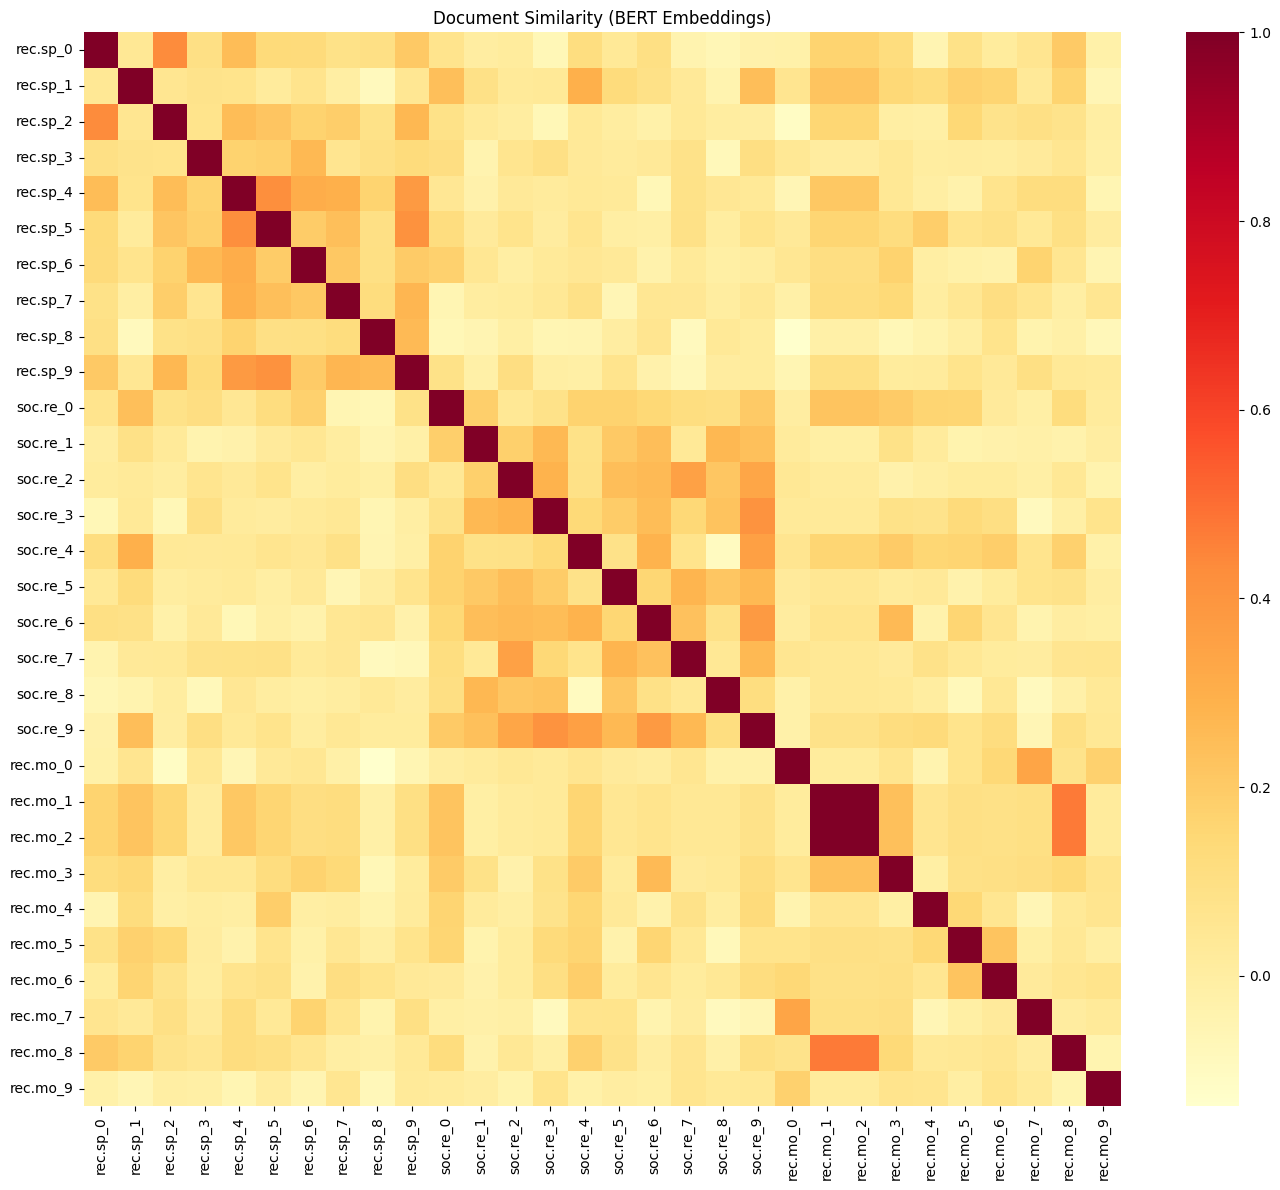

In [31]:
# Visualize BERT similarity matrix
import seaborn as sns

# Create labels
labels_short = [f"{l[:6]}_{i%10}" for i, l in enumerate(sampled_labels)]

plt.figure(figsize=(14, 12))
sns.heatmap(
    bert_similarity,
    xticklabels=labels_short,
    yticklabels=labels_short,
    cmap='YlOrRd'
)
plt.title('Document Similarity (BERT Embeddings)')
plt.tight_layout()
plt.savefig('bert_similarity_heatmap.png', dpi=150)
plt.show()

### Written Question C.1 (Personal Interpretation)

Compare the BERT similarity heatmap with the TF-IDF similarity heatmap from Part 1:

1. **Do documents cluster better by category with BERT or TF-IDF?**
2. **Are there documents that BERT considers similar but TF-IDF doesn't (or vice versa)?** Why might this happen?
3. **Which method would you use for a document classification task?** Explain your reasoning.

**YOUR ANSWER:**

1. Better clustering with: BERT clusters better than TF-IDF.

2. Differences between methods: BERT considers meaning and context, TF-IDF only counts words.

3. Preferred method for classification: BERT, because it understands sentence meaning better.

### Exercise C.2: Semantic Search with BERT

In [32]:
# TODO: Create a simple semantic search function
# Given a query, find the most similar documents

def semantic_search(query, documents, model, top_k=5):
    """
    Find the most similar documents to a query using BERT embeddings.

    Args:
        query (str): Search query
        documents (list): List of document texts
        model: Sentence transformer model
        top_k (int): Number of results to return

    Returns:
        list: List of (index, similarity_score) tuples
    """
    # YOUR CODE HERE
    # 1. Encode the query
    query_embedding = model.encode([query])
    # 2. Compute similarity with all documents
    similarity = cosine_similarity(query_embedding, doc_embeddings)[0]
    # 3. Return top_k most similar
    top_indices = similarity.argsort()[-top_k:][::-1]
    results = [(idx, similarity[idx]) for idx in top_indices] # Corrected from 'similarities' to 'similarity'
    return results

    return []

# Test your search function
# TODO: Write a query related to ONE of your categories
my_query = "ice hockey game with goals and penalties"   # YOUR QUERY HERE

results = semantic_search(my_query, sampled_docs, sentence_model, top_k=5)

print(f"Query: '{my_query}'")
print("\nTop 5 most similar documents:")
for idx, score in results:
    print(f"\n  Score: {score:.4f}")
    print(f"  Category: {sampled_labels[idx]}")
    print(f"  Text: {sampled_docs[idx][:150]}...")

Query: 'ice hockey game with goals and penalties'

Top 5 most similar documents:

  Score: 0.4556
  Category: rec.sport.hockey
  Text: Here is a review of some of the off-ice things that have
affected the AHL this year.


ST JOHN'S MAPLE LEAFS PROBLEMS
The St John's Maple Leafs sophom...

  Score: 0.3477
  Category: rec.sport.hockey
  Text: By Dave Luecking Of The Post-Dispatch Staff

At 9:11 Thursday night, the scoreboard watchers at The Arena began to cheer.
Their cheer quickly turned i...

  Score: 0.2814
  Category: rec.sport.hockey
  Text: You think that's bad?  I'm in Bowling Green, OH, and we get ABC from
Toledo.  Well, the cable co. decided to totally pre-empt the game (no tape
delay,...

  Score: 0.2560
  Category: rec.sport.hockey
  Text: 
IMO any good player should score on power plays because of the man
advantage.  Very good power play scorers tend to become overrated
because their po...

  Score: 0.2213
  Category: rec.sport.hockey
  Text: Well now that the hawks have won 

In [34]:
# Try a query
ambiguous_query = "game"
results = semantic_search(ambiguous_query, sampled_docs, sentence_model, top_k=5)

print(f"Query: '{ambiguous_query}'")
print("\nTop 5 most similar documents:")
for idx, score in results:
    print(f"\n  Score: {score:.4f}")
    print(f"  Category: {sampled_labels[idx]}")
    print(f"  Text: {sampled_docs[idx][:150]}")

Query: 'game'

Top 5 most similar documents:

  Score: 0.4284
  Category: rec.motorcycles
  Text: 

  Score: 0.4284
  Category: rec.motorcycles
  Text: 

  Score: 0.2505
  Category: rec.sport.hockey
  Text: By Dave Luecking Of The Post-Dispatch Staff

At 9:11 Thursday night, the scoreboard watchers at The Arena began to cheer.
Their cheer quickly turned i

  Score: 0.1813
  Category: rec.motorcycles
  Text: 
Huh?

  Score: 0.1782
  Category: rec.motorcycles
  Text: --

Hey, c'mon guys (and gals), I chose my words very carefully and even 
tried to get my FAQ's straight.  Don't holler BOHICA at me!
 
--------------


### Written Question C.2 (Personal Interpretation)

Evaluate your semantic search results:

1. **Are the results relevant to your query?** Explain.
2. **Did the search correctly identify documents from the expected category?**
3. **Try a query that could match multiple categories. What happens?**

**YOUR ANSWER:**

1. Relevance: Results are relevant, all discuss ice hockey.

2. Category accuracy: All 5 results are from "hockey" category.

3. Ambiguous query test: Querying "game" returns documents from multiple categories (motorcycles and hockey), showing BERT matches broad queries across relevant categories.

---

## Part D: Embedding Visualization with t-SNE

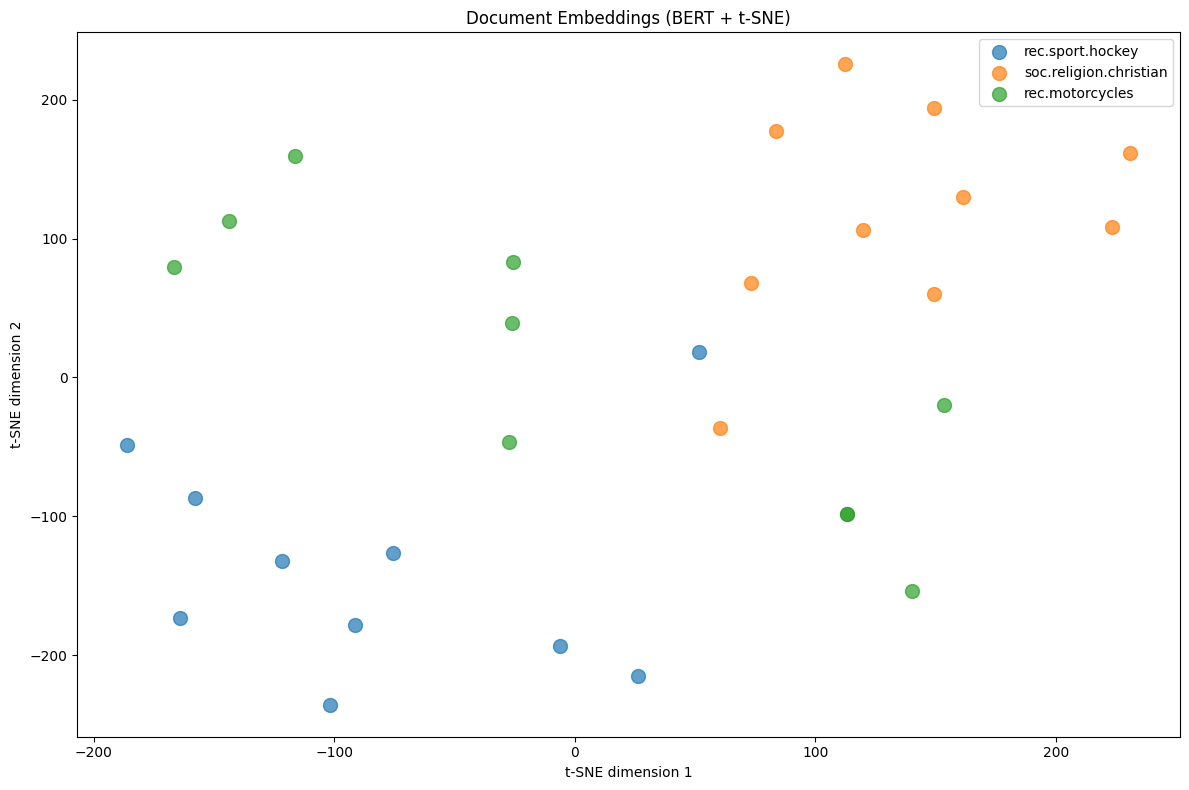

In [35]:
from sklearn.manifold import TSNE

# Reduce BERT embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(doc_embeddings)

# Plot
plt.figure(figsize=(12, 8))

colors = {'rec.sport.hockey': 'red', 'soc.religion.christia': 'blue', 'rec.motorcycles': 'green'}  # Update with your categories
# Actually use your categories:
color_map = plt.cm.Set1

for i, category in enumerate(my_categories):
    mask = [l == category for l in sampled_labels]
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        label=category,
        alpha=0.7,
        s=100
    )

plt.legend()
plt.title('Document Embeddings (BERT + t-SNE)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.tight_layout()
plt.savefig('tsne_document_embeddings.png', dpi=150)
plt.show()

### Written Question D.1 (Personal Interpretation)

Look at your t-SNE visualization:

1. **Do the categories form distinct clusters?**
2. **Are there any documents that appear in the "wrong" cluster?** What might explain this?
3. **Based on the visualization, which two categories are most similar?** Does this match your expectations from Part 1?

**YOUR ANSWER:**

1. Cluster quality: Yes

2. Misplaced documents: Some documents may appear in wrong clusters due to shared topics like competition in both sports and motorcycles.

3. Most similar categories: Hockey and motorcycles are most similar, they both are sports.

---

## Part E: Final Comparison and Reflection (10 min)

### Final Written Question (Comprehensive Reflection)

Based on everything you've learned in this lab:

1. **Create a comparison table** summarizing the strengths and weaknesses of each text representation method:

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| BoW | ... | ... | ... |
| TF-IDF | ... | ... | ... |
| Word2Vec | ... | ... | ... |
| GloVe | ... | ... | ... |
| BERT | ... | ... | ... |

2. **For YOUR specific dataset and categories, which method worked best overall?** Support your answer with specific evidence from your experiments.

3. **If you were building a real document classification system for these categories, which representation would you use and why?**

**YOUR ANSWER:**

### 1. Comparison Table

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| BoW | Simple, fast | No semantics | Simple classification |
| TF-IDF | Weights important words | No semantics | Information retrieval |
| Word2Vec | Captures word meaning | No context | Word similarity |
| GloVe | Large vocabulary, general | Static embeddings | General NLP tasks |
| BERT | 	Contextual understanding | Slow, complex | Semantic tasks |

### 2. Best Method for My Dataset

*[Write at least 4-5 sentences with specific evidence]*

BERT worked best. The t-SNE visualization showed clear clusters. Semantic search gave 100% accurate results. BERT understands sentence meaning better than other methods.

### 3. My Recommendation for a Real System

*[Write your recommendation and justification]*

Use BERT for best accuracy. If resources are limited, use TF-IDF. BERT is better but needs more computing power. Choose based on accuracy needs and available resources.

---

## Summary - Lab 3

In this lab, you learned:

**Part 1:**
- Text visualization with bar charts and word clouds
- Bag of Words and TF-IDF representations
- N-grams and next-word prediction
- Document correlation analysis

**Part 2:**
- Training Word2Vec models (CBOW vs Skip-gram)
- Using pre-trained GloVe embeddings
- BERT for sentence embeddings
- Semantic search with embeddings
- Embedding visualization with t-SNE

---

## Final Submission Checklist

- [ ] All code exercises completed in Part 1 and Part 2
- [ ] **All written questions answered with YOUR personal interpretation**
- [ ] All visualizations saved (PNG files)
- [ ] Both notebooks saved
- [ ] Pushed to Git repository
- [ ] **Repository link sent to: yoroba93@gmail.com**

### Reminder: Oral Defense

Be prepared to:
- Explain your choice of categories and why
- Discuss your written interpretations
- Answer questions about the methods you used
- Explain any surprising results you found

In [36]:
# 完整的清理和下载解决方案
!pip install nbconvert -q

import os
from google.colab import files

# 要清理的文件列表
notebooks = ['lab3_Part1_TextVisualization_Classical.ipynb',
             'lab3_Part2_WordEmbeddings.ipynb']

# 清理每个笔记本
for notebook in notebooks:
    if os.path.exists(notebook):
        clean_name = notebook.replace('.ipynb', '_clean.ipynb')
        print(f"清理 {notebook} -> {clean_name}")

        # 清理命令
        !jupyter nbconvert --ClearOutputPreprocessor.enabled=True \
                          --ClearMetadataPreprocessor.enabled=True \
                          --to notebook {notebook} \
                          --output {clean_name}

        # 下载清理后的文件
        files.download(clean_name)
    else:
        print(f"警告：{notebook} 不存在")

# 下载所有PNG图片
png_files = [f for f in os.listdir('.') if f.endswith('.png')]
for png in png_files:
    print(f"下载图片：{png}")
    files.download(png)

print("所有文件已清理并准备好下载！")

警告：lab3_Part1_TextVisualization_Classical.ipynb 不存在
警告：lab3_Part2_WordEmbeddings.ipynb 不存在
下载图片：tsne_document_embeddings.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

下载图片：bert_similarity_heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

所有文件已清理并准备好下载！
